<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# Plot 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.title("Train vs Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

[MYCODE] 테스트 데이터 준비하기

In [ ]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

In [14]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

[MYCODE] 테스트로더 만들기

In [ ]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

[MYCODE] nn.CrossEntropyLoss 적용하기
- layer3 번째 활성 함수 삭제 최종 클래스 수를 10개로 지정하였습니다.

[FEEDBACK] 출력층의 레이어 활성함수 삭제

1. 세번째 출력층의 레이어에 활성함수를 두지 않는 근거를 어떻게 찾아야할까요?     
분류 문제이기 때문에 활성함수를 사용하지 않는다가 근거가 되는걸까요?

2. 출력 노드 수를 10개로 지정하는 기준은 예측해야하는가 아니면 하드코딩 방식으로만 가능할까요?     
예) 0~9가 10개 -> 노드의 수10개


In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # 활성함수를 삭제
    return self.layer3(x)


model = Model(28 * 28, 1024).to('cuda')

In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

[MYCODE] nn.CrossEntropyLoss 적용하기

In [15]:
cretaition = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 100

# Lists for Accuracy Tracking
train_accs = []
test_accs = []


for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    #print(f"모델 출력 크기: {preds.shape}")
    #print(f"모델 출력 값(샘플): {preds[0]}")

    assert labels.min() >= 0, "음수 값이 포함되어 있습니다!"
    assert labels.max() < 10, "클래스 개수를 초과합니다!"
    assert labels.dtype == torch.int64, "라벨 타입이 torch.LongTensor가 아닙니다!"

    loss = cretaition(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # Epoch 종료 후 정확도 계산
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss / len(trainloader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")



Epoch 1/100, Loss: 2.2717, Train Acc: 0.5399, Test Acc: 0.5412
Epoch 2/100, Loss: 2.1914, Train Acc: 0.6212, Test Acc: 0.6259
Epoch 3/100, Loss: 2.0626, Train Acc: 0.6753, Test Acc: 0.6795
Epoch 4/100, Loss: 1.8439, Train Acc: 0.7157, Test Acc: 0.7257
Epoch 5/100, Loss: 1.5310, Train Acc: 0.7530, Test Acc: 0.7621
Epoch 6/100, Loss: 1.2122, Train Acc: 0.7897, Test Acc: 0.7984
Epoch 7/100, Loss: 0.9735, Train Acc: 0.8143, Test Acc: 0.8204
Epoch 8/100, Loss: 0.8149, Train Acc: 0.8300, Test Acc: 0.8347
Epoch 9/100, Loss: 0.7086, Train Acc: 0.8409, Test Acc: 0.8477
Epoch 10/100, Loss: 0.6343, Train Acc: 0.8518, Test Acc: 0.8568
Epoch 11/100, Loss: 0.5800, Train Acc: 0.8596, Test Acc: 0.8644
Epoch 12/100, Loss: 0.5388, Train Acc: 0.8664, Test Acc: 0.8713
Epoch 13/100, Loss: 0.5063, Train Acc: 0.8724, Test Acc: 0.8771
Epoch 14/100, Loss: 0.4802, Train Acc: 0.8767, Test Acc: 0.8822
Epoch 15/100, Loss: 0.4587, Train Acc: 0.8802, Test Acc: 0.8872
Epoch 16/100, Loss: 0.4411, Train Acc: 0.8844, Te

NameError: name 'np' is not defined

[MYCODE] 정확도 PLOT 하기

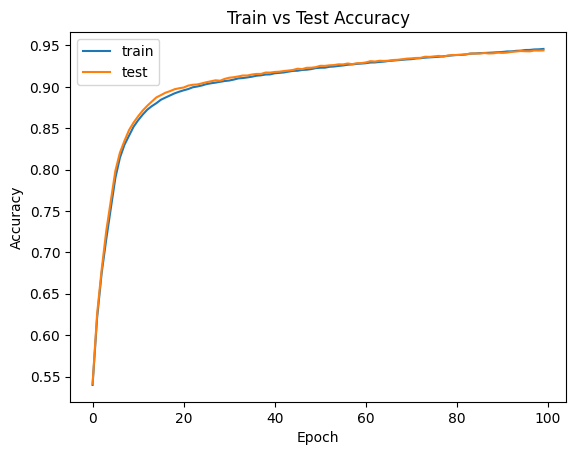

In [ ]:
# 정확도 Plot
plot_acc(train_accs, test_accs)

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
idx = 2

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[-2.5199, -2.4164,  1.9595,  0.9697,  5.2154, -2.3672, -0.7989,  1.1618,
         -1.3375,  0.5404]], device='cuda:0', grad_fn=<AddmmBackward0>)
4


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.